## Strong features/indicators to daily cases for Pahang, Kedah, Johor and Selangor

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading and cleaning

In [2]:
cases_state = pd.read_csv('./data/cases_state.csv')
cases_state.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1'], inplace=True)

deaths_state = pd.read_csv('./data/deaths_state.csv')
deaths_state.fillna(0, inplace=True)

tests_state = pd.read_csv('./data/tests_state.csv')
tests_state.fillna(0, inplace=True)
tests_state.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1'], inplace=True)
tests_state.rename(columns={'total': 'tests'}, inplace=True)

quarantine_state = pd.read_csv('./data/pkrc.csv')
quarantine_state.fillna(0, inplace=True)
quarantine_state.rename(columns={'beds': 'pkrc_beds', 'admitted_pui': 'pkrc_admitted_pui', 'admitted_covid': 'pkrc_admitted_covid', 'discharge_covid': 'pkrc_discharge_covid', 'admitted_total': 'pkrc_admitted_total'}, inplace=True)

icu_state = pd.read_csv('./data/icu.csv')
icu_state.fillna(0, inplace=True)

hospital = pd.read_csv('./data/hospital.csv')
hospital.fillna(0, inplace=True)

population_state = pd.read_csv('./data/population.csv', index_col=0)
population_state.fillna(0, inplace=True)

For feature selection, we don't just take every single feature across the datasets. Even though some might be good predictors, they are not sensible as features for case prediction. Therefore, in the first round, we handpick features we feel are relevant and then pass it into the feature selection function. The methodology is summarised below:
1. Handpick first feature set
2. Feature selection to get the best features from this feature set

In [3]:
#create a dataframe that only store the data of the states we need only

states_list = ['Pahang', 'Kedah', 'Johor', 'Selangor']
states = {}

relevant_columns = ['cases_new', 'deaths_new', 'tests', 'admitted_covid', 'discharge_covid', 'pkrc_covid', 'pkrc_admitted_covid', 'pkrc_discharge_covid', 'icu_covid', 'hosp_covid', 'vent_covid', 'beds_covid', 'pkrc_beds']
for state in states_list:
    df = cases_state[cases_state['state'] == state]
    df = df.merge(deaths_state[deaths_state['state'] == state], how='inner', on=['date', 'state'], )
    df.fillna(0, inplace=True)
    df = df.merge(quarantine_state[quarantine_state['state'] == state], how='inner', on=['date', 'state'])
    df.fillna(0, inplace=True)
    df = df.merge(icu_state[icu_state['state'] == state], how='inner', on=['date', 'state'])
    df.fillna(0, inplace=True)
    df = df.merge(hospital[hospital['state'] == state], how='inner', on=['date', 'state'])
    df.fillna(0, inplace=True)
    df = df.merge(tests_state[tests_state['state'] == state], how='left', on=['date', 'state'])
    df.fillna(0, inplace=True)
    df.set_index('date', inplace=True)
    print(df.columns)
    df.drop(columns=[col for col in df.columns if col not in relevant_columns], inplace=True)
    states[state] = df

Index(['Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1_x', 'state', 'cases_import',
       'cases_new', 'cases_recovered', 'deaths_new', 'deaths_new_dod',
       'deaths_bid', 'deaths_bid_dod', 'pkrc_beds', 'pkrc_admitted_pui',
       'pkrc_admitted_covid', 'pkrc_admitted_total', 'discharge_pui',
       'pkrc_discharge_covid', 'discharge_total', 'pkrc_covid', 'pkrc_pui',
       'pkrc_noncovid', 'beds_icu', 'beds_icu_rep', 'beds_icu_total',
       'beds_icu_covid', 'vent', 'vent_port', 'icu_covid', 'icu_pui',
       'icu_noncovid', 'vent_covid', 'vent_pui', 'vent_noncovid', 'beds',
       'beds_covid', 'beds_noncrit', 'admitted_pui', 'admitted_covid',
       'admitted_total', 'discharged_pui', 'discharged_covid',
       'discharged_total', 'hosp_covid', 'hosp_pui', 'hosp_noncovid',
       'Unnamed: 0.1.1.1.1.1_y', 'Unnamed: 0.1.1.1.1.1.1', 'rtk-ag', 'pcr',
       'tests'],
      dtype='object')
Index(['Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1_x', 'state', 'cases_import',
       'cases_new

In [4]:
#testing the new dataframe with Pahang State
states['Pahang']

,cases_new,deaths_new,pkrc_beds,pkrc_admitted_covid,pkrc_discharge_covid,pkrc_covid,icu_covid,vent_covid,beds_covid,admitted_covid,hosp_covid,tests
date,,,,,,,,,,,,
2020-04-09,14,0,66,16,0,36,3,3,504,13,90,0.0
2020-04-10,4,0,66,1,3,28,4,3,497,4,87,0.0
2020-04-11,27,0,66,6,2,32,4,3,497,29,109,0.0
2020-04-12,11,0,66,0,4,28,4,3,497,9,116,0.0
2020-04-13,0,0,66,1,8,21,4,3,497,0,114,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,715,3,4265,325,281,3080,41,20,734,45,454,7564.0
2021-09-02,599,0,4265,248,320,2831,43,21,734,52,449,6444.0
2021-09-03,559,4,4265,273,291,3003,44,28,734,61,452,7182.0


Remove columns that are unrelated to covid first as the first round of feature selection.

## Finding Best Features

Techniques Used:
1. Boruta with Random Forest Regression
2. SelectKBest with Mutual Info Regression
4. Recursive Feature Elimination

In [5]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression, RFE, VarianceThreshold
from sklearn.linear_model import LinearRegression
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

#the function we use to find the best features

def get_best_features(df,display_scatter_plots = 0):
    X = df.drop(columns=['cases_new'], axis=1)
    y = df['cases_new']
    print(X.columns)
    # selector = VarianceThreshold(3)
    # selector.fit(df.drop(columns=['state']))
    # variance_best = df.columns[selector.get_support()]

    selector = SelectKBest(mutual_info_regression, k=6)
    selector.fit(X, y)
    mutual_info_best = X.columns[selector.get_support()]

    rfe_selector = RFE(LinearRegression(), n_features_to_select=10)
    rfe_selector.fit(X, y)
    rfe_best = X.columns[rfe_selector.get_support()]

    rf = RandomForestRegressor(n_jobs=4, oob_score=True)
    boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=0)
    boruta.fit(X.values, y.ravel())
    boruta_best = [X.columns[i] for i, x in enumerate(boruta.support_) if x]
    print('')
    print(boruta_best)
    print('')

    columns = X.columns
    columns_count = {}
    for column in columns:
        columns_count[column] = list(mutual_info_best).count(column) + list(rfe_best).count(column) + list(boruta_best).count(column)
    
    best_features = sorted(columns_count, key=columns_count.get)[-6:]
        
    if display_scatter_plots == 1:
        print("The best four features")
        display(best_features)
        print("")
        for num in range(len(best_features)):
            sns.scatterplot(x= best_features[num], y="cases_new", data=df)
            z = np.polyfit(df[best_features[num]], df['cases_new'], 1)
            p = np.poly1d(z)
            plt.plot(df[best_features[num]],p(df[best_features[num]]),"r--")
            plt.title('Scatter plot of ' + best_features[num] + ' and daily new cases')
            plt.xlabel(best_features[num])
            plt.ylabel("daily new cases")
            plt.show()

    # if 'tests' not in best_features:
    #     best_features.append('tests')

    return best_features

<b>Pahang Best Features and Results<b>

Index(['deaths_new', 'pkrc_beds', 'pkrc_admitted_covid',
       'pkrc_discharge_covid', 'pkrc_covid', 'icu_covid', 'vent_covid',
       'beds_covid', 'admitted_covid', 'hosp_covid', 'tests'],
      dtype='object')
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2
Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2
Iteration: 	10 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2
Iteration: 	11 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2
Iteration: 	12 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	2
Iteration: 	13 / 100
Confirmed: 	7
Tentative

['tests',
 'pkrc_admitted_covid',
 'pkrc_covid',
 'icu_covid',
 'vent_covid',
 'hosp_covid']

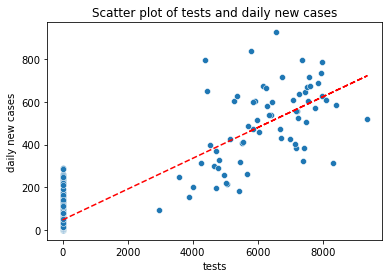

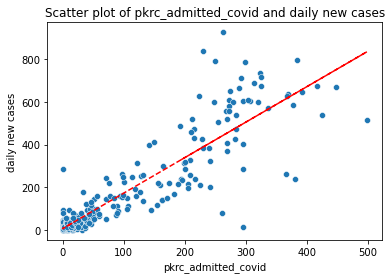

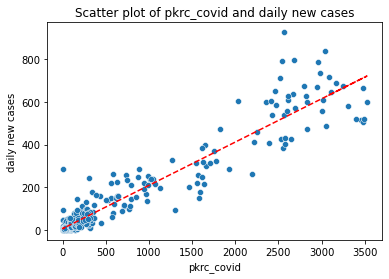

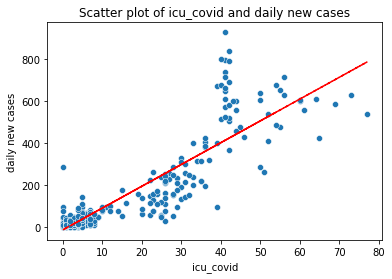

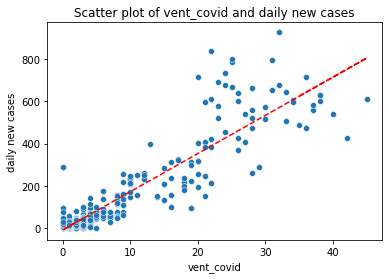

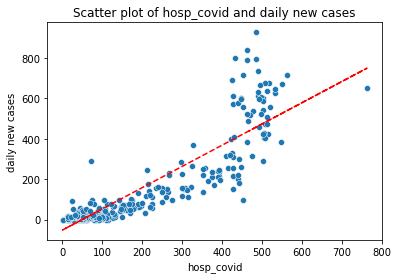

In [6]:
pahang_features = get_best_features(states['Pahang'],display_scatter_plots = 1)


<h4>Kedah Best Features and Results<h4>

Index(['deaths_new', 'pkrc_beds', 'pkrc_admitted_covid',
       'pkrc_discharge_covid', 'pkrc_covid', 'icu_covid', 'vent_covid',
       'beds_covid', 'admitted_covid', 'hosp_covid', 'tests'],
      dtype='object')
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	1
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	1
Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	1
Iteration: 	11 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	1
Iteration: 	12 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	1
Iteration: 	13 / 100
Confirmed: 	6
Tentative

['vent_covid',
 'pkrc_covid',
 'icu_covid',
 'beds_covid',
 'admitted_covid',
 'hosp_covid']

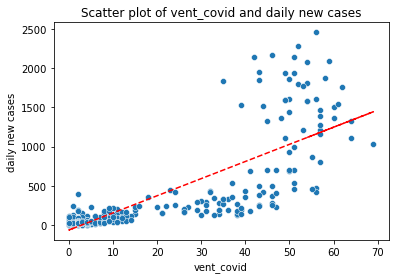

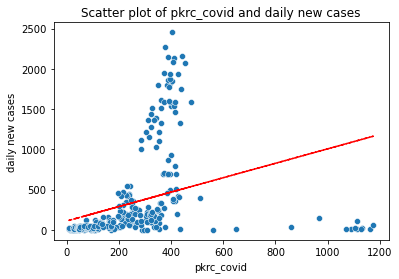

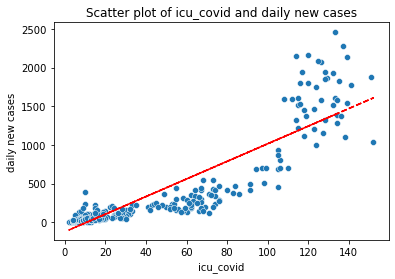

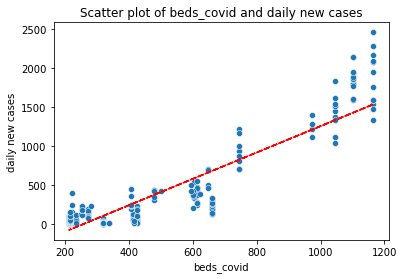

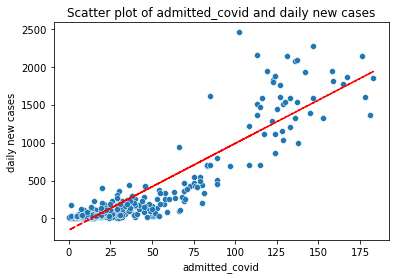

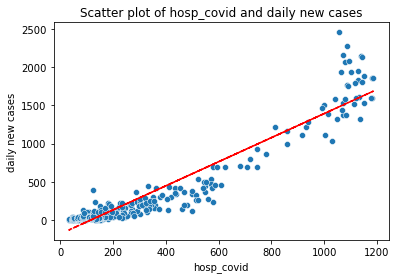

In [7]:
kedah_features = get_best_features(states['Kedah'],display_scatter_plots = 1)

<b>Johor Best Features and Results</b>

Index(['deaths_new', 'pkrc_beds', 'pkrc_admitted_covid',
       'pkrc_discharge_covid', 'pkrc_covid', 'icu_covid', 'vent_covid',
       'beds_covid', 'admitted_covid', 'hosp_covid', 'tests'],
      dtype='object')
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	4
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	4
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	7
Tentative: 	4
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	7
Tentative: 	4
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	7
Tentative: 	4
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	7
Tentative

['pkrc_beds',
 'pkrc_covid',
 'icu_covid',
 'vent_covid',
 'beds_covid',
 'hosp_covid']

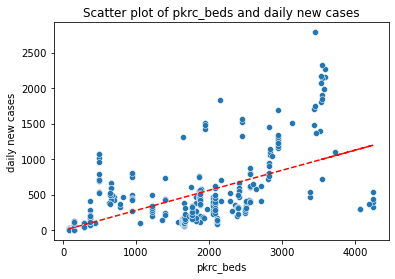

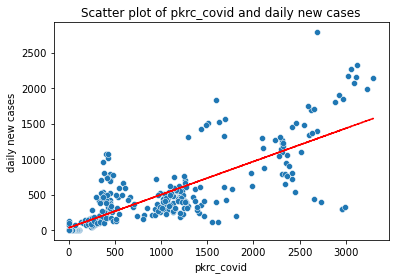

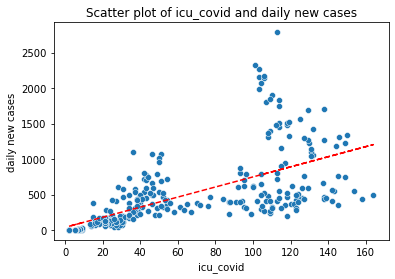

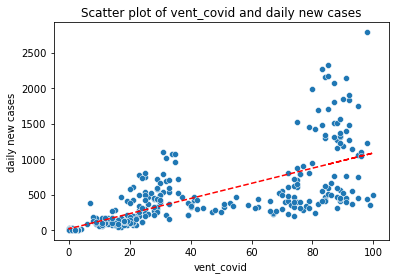

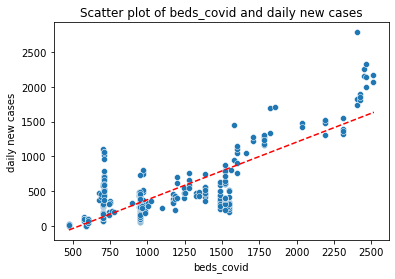

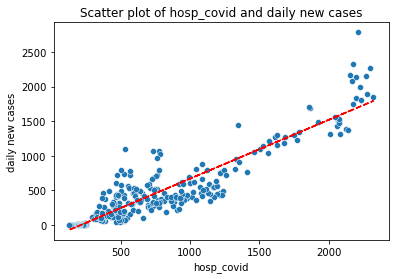

In [8]:
johor_features = get_best_features(states['Johor'],display_scatter_plots = 1)

<b>Selangor Best Features and Results</b>

Index(['deaths_new', 'pkrc_beds', 'pkrc_admitted_covid',
       'pkrc_discharge_covid', 'pkrc_covid', 'icu_covid', 'vent_covid',
       'beds_covid', 'admitted_covid', 'hosp_covid', 'tests'],
      dtype='object')
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	2
Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	2
Iteration: 	10 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	2
Iteration: 	11 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	2
Iteration: 	12 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	2
Iteration: 	13 / 100
Confirmed: 	8
Tentative

['vent_covid',
 'pkrc_beds',
 'icu_covid',
 'beds_covid',
 'admitted_covid',
 'hosp_covid']

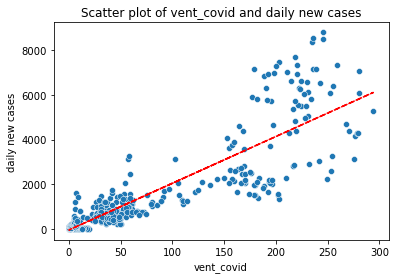

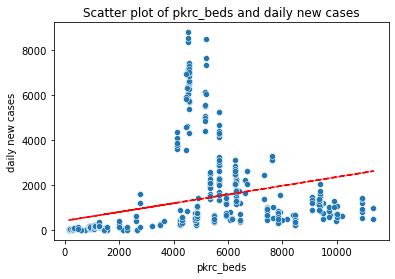

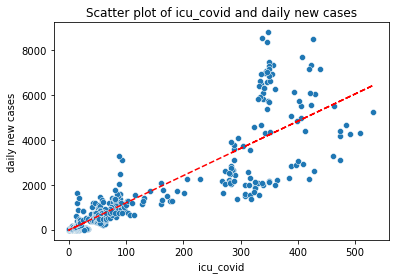

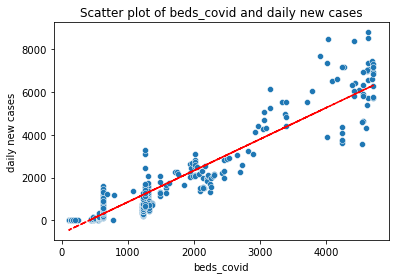

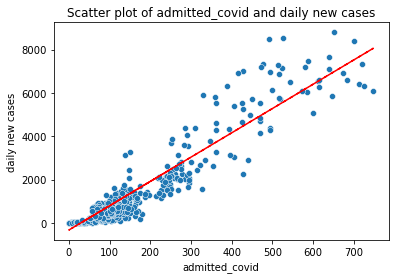

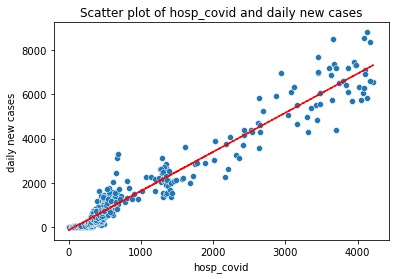

In [9]:
selangor_features = get_best_features(states['Selangor'],display_scatter_plots = 1)

<h1>Q3 (iv)<h1>
<b>Comparing regression and classification models, what model performs well in
predicting the daily cases for (i) Pahang, (ii) Kedah, (iii) Johor, and (iv) Selangor?</b>

## Modeling
Regression:
1. Support Vector Machine
2. Linear Regression
3. Random Forest Regressor

Classification:
1. Support Vector Machine
2. Decision Tree
3. Logistic

In [10]:
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, mean_squared_error

## Regression

In [11]:
#function for Support Vector Machine Regression
def svm_regression(df, features):
    X = df[features]
    X = MinMaxScaler().fit_transform(X)
    y = df['cases_new']
    y = MinMaxScaler().fit_transform(y.values.reshape(-1, 1))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    svr_rbf = SVR(kernel='rbf', C=1e5, gamma=0.001)
    svr_rbf.fit(X_train, y_train.ravel())
    svr_rbf_pred = svr_rbf.predict(X_test)

    svr_rbf_score = svr_rbf.score(X_test, y_test)
    svr_rbf_mse = mean_squared_error(y_test, svr_rbf_pred)

    print('SVR RBF Score: ', svr_rbf_score)
    print('SVR RBF MSE: ', svr_rbf_mse)
    print('')


In [12]:
#function for Linear Regression
def linear_regression(df, features):
    X = df[features]
    X = MinMaxScaler().fit_transform(X)
    y = df['cases_new']
    y = MinMaxScaler().fit_transform(y.values.reshape(-1, 1))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    lin_reg_pred = lin_reg.predict(X_test)

    lin_reg_score = lin_reg.score(X_test, y_test)
    lin_reg_mse = mean_squared_error(y_test, lin_reg_pred)

    print('Linear Regression Score: ', lin_reg_score)
    print('Linear Regression MSE: ', lin_reg_mse)
    print('')

In [13]:
#function for Random Forest Regressor
def random_forest_regressor(df, features):
    X = df[features]
    X = MinMaxScaler().fit_transform(X)
    y = df['cases_new']
    y = MinMaxScaler().fit_transform(y.values.reshape(-1, 1))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    rf_reg = RandomForestRegressor(n_estimators=10, random_state=42)
    rf_reg.fit(X_train, y_train.ravel())
    rf_reg_pred = rf_reg.predict(X_test)

    rf_reg_score = rf_reg.score(X_test, y_test)
    rf_reg_mse = mean_squared_error(y_test, rf_reg_pred)

    print('Random Forest Regressor Score: ', rf_reg_score)
    print('Random Forest Regressor MSE: ', rf_reg_mse)
    print('')

In [14]:
best_features = {}
best_features['Pahang'] = pahang_features
best_features['Kedah'] = kedah_features
best_features['Selangor'] = selangor_features
best_features['Johor'] = johor_features

In [15]:
#function to print out the results for specify's state
def print_result_for_regression_models(state):
    svm_regression(states[state], best_features[state])
    linear_regression(states[state], best_features[state])
    random_forest_regressor(states[state], best_features[state])

## Classification

In [16]:
from sklearn.metrics import classification_report

In [17]:
for state in states_list:
    states[state]['cases_binned'] = pd.cut(states[state]['cases_new'], bins=[-1, states[state]['cases_new'].max()/3, 2/3 * states[state]['cases_new'].max(), states[state]['cases_new'].max()], labels=['Low', 'Medium', 'High'])

In [18]:
#function for Support Vector Machine classification
def supportvectormachine_classification(df, features):
    X = df[features]
    X = MinMaxScaler().fit_transform(X)
    y = df['cases_binned']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    svc = SVC(kernel='rbf', C=1e5, gamma=0.001)
    svc.fit(X_train, y_train)
    svc_pred = svc.predict(X_test)

    svc_score = svc.score(X_test, y_test)
    svc_f1_score = f1_score(y_test, svc_pred, average='weighted')

    # print classification report
    print(classification_report(y_test, svc_pred))

    print('SVC Score: ', svc_score)
    print('SVC F1 Score: ', svc_f1_score)
    print('')

In [19]:
#function for Decision Tree 
def randomforest_classification(df, features):
    X = df[features]
    X = MinMaxScaler().fit_transform(X)
    y = df['cases_binned']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    rf_clf = RandomForestClassifier(n_estimators=5, random_state=42)
    rf_clf.fit(X_train, y_train)
    rf_clf_pred = rf_clf.predict(X_test)

    rf_clf_score = rf_clf.score(X_test, y_test)
    rf_clf_f1_score = f1_score(y_test, rf_clf_pred, average='weighted')

    # print classification report
    print(classification_report(y_test, rf_clf_pred))

    print('Random Forest Classification Score: ', rf_clf_score)
    print('Random Forest Classification F1 Score: ', rf_clf_f1_score)
    print('')

In [20]:
#function for Logistic Regression
def logistic_regression(df, features):
    X = df[features]
    X = MinMaxScaler().fit_transform(X)
    y = df['cases_binned']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    log_reg = LogisticRegression(random_state=42)
    log_reg.fit(X_train, y_train)
    log_reg_pred = log_reg.predict(X_test)

    log_reg_score = log_reg.score(X_test, y_test)
    log_reg_f1_score = f1_score(y_test, log_reg_pred, average='weighted')

    # print classification report
    print(classification_report(y_test, log_reg_pred))

    print('Logistic Regression Score: ', log_reg_score)
    print('Logistic Regression F1 Score: ', log_reg_f1_score)
    print('')

In [21]:
#function to print out the results for specify's state
def print_result_for_classificaiton_models(state) :
    supportvectormachine_classification(states[state], best_features[state])
    randomforest_classification(states[state], best_features[state])
    logistic_regression(states[state], best_features[state])

<b>Pahang</b>

<blockquote>Regression Results</blockquote>

In [22]:
print_result_for_regression_models('Pahang')

SVR RBF Score:  0.8403670633703122
SVR RBF MSE:  0.008202458064607086

Linear Regression Score:  0.9027166552969977
Linear Regression MSE:  0.004998733796160026

Random Forest Regressor Score:  0.9109786769357175
Random Forest Regressor MSE:  0.004574204325918658



<blockquote>Classification Results</blockquote>

In [23]:
print_result_for_classificaiton_models('Pahang')

              precision    recall  f1-score   support

        High       0.00      0.00      0.00         4
         Low       1.00      1.00      1.00        59
      Medium       0.60      0.86      0.71         7

    accuracy                           0.93        70
   macro avg       0.53      0.62      0.57        70
weighted avg       0.90      0.93      0.91        70

SVC Score:  0.9285714285714286
SVC F1 Score:  0.9134453781512605

              precision    recall  f1-score   support

        High       0.33      0.25      0.29         4
         Low       1.00      0.98      0.99        59
      Medium       0.56      0.71      0.63         7

    accuracy                           0.91        70
   macro avg       0.63      0.65      0.63        70
weighted avg       0.92      0.91      0.91        70

Random Forest Classification Score:  0.9142857142857143
Random Forest Classification F1 Score:  0.9144797662654808

              precision    recall  f1-score   support

 

C:\Users\kaneu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kaneu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kaneu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<b>Kedah</b>

<blockquote>Regression Results</blockquote>

In [24]:
print_result_for_regression_models('Kedah')

SVR RBF Score:  0.9564926404871119
SVR RBF MSE:  0.0029304155708293287

Linear Regression Score:  0.9476851227846464
Linear Regression MSE:  0.003523641344689818

Random Forest Regressor Score:  0.9663215147713625
Random Forest Regressor MSE:  0.002268396855633339



<blockquote>Classification Results</blockquote>

In [25]:
print_result_for_classificaiton_models('Kedah')

              precision    recall  f1-score   support

        High       0.60      0.50      0.55         6
         Low       1.00      1.00      1.00        54
      Medium       0.67      0.75      0.71         8

    accuracy                           0.93        68
   macro avg       0.76      0.75      0.75        68
weighted avg       0.93      0.93      0.93        68

SVC Score:  0.9264705882352942
SVC F1 Score:  0.9252909720037747

              precision    recall  f1-score   support

        High       0.67      0.67      0.67         6
         Low       1.00      1.00      1.00        54
      Medium       0.75      0.75      0.75         8

    accuracy                           0.94        68
   macro avg       0.81      0.81      0.81        68
weighted avg       0.94      0.94      0.94        68

Random Forest Classification Score:  0.9411764705882353
Random Forest Classification F1 Score:  0.9411764705882353

              precision    recall  f1-score   support

 

C:\Users\kaneu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kaneu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kaneu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<b>Johor</b>

<blockquote>Regression Results</blockquote>

In [26]:
print_result_for_regression_models('Johor')

SVR RBF Score:  0.8440146517061662
SVR RBF MSE:  0.006177991875488241

Linear Regression Score:  0.8662445038291386
Linear Regression MSE:  0.005297551197493757

Random Forest Regressor Score:  0.9051059920396347
Random Forest Regressor MSE:  0.003758394083957874



<blockquote>Classification Results</blockquote>

In [27]:
print_result_for_classificaiton_models('Johor')

              precision    recall  f1-score   support

        High       0.50      0.50      0.50         2
         Low       0.98      1.00      0.99        53
      Medium       0.89      0.80      0.84        10

    accuracy                           0.95        65
   macro avg       0.79      0.77      0.78        65
weighted avg       0.95      0.95      0.95        65

SVC Score:  0.9538461538461539
SVC F1 Score:  0.9527034696734649

              precision    recall  f1-score   support

        High       0.50      0.50      0.50         2
         Low       0.98      0.98      0.98        53
      Medium       0.80      0.80      0.80        10

    accuracy                           0.94        65
   macro avg       0.76      0.76      0.76        65
weighted avg       0.94      0.94      0.94        65

Random Forest Classification Score:  0.9384615384615385
Random Forest Classification F1 Score:  0.9384615384615385

              precision    recall  f1-score   support

 

C:\Users\kaneu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kaneu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kaneu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<b>Selangor</b>

<blockquote>Regression Results</blockquote>

In [28]:
print_result_for_regression_models('Selangor')

SVR RBF Score:  0.9461939461922559
SVR RBF MSE:  0.002877390656609478

Linear Regression Score:  0.9608172240040476
Linear Regression MSE:  0.0020953804557685097

Random Forest Regressor Score:  0.9565512670186063
Random Forest Regressor MSE:  0.0023235113797583314



<blockquote>Classification Results</blockquote>

In [29]:
print_result_for_classificaiton_models('Selangor')

              precision    recall  f1-score   support

        High       0.83      0.83      0.83         6
         Low       1.00      0.99      0.99        89
      Medium       0.83      0.91      0.87        11

    accuracy                           0.97       106
   macro avg       0.89      0.91      0.90       106
weighted avg       0.97      0.97      0.97       106

SVC Score:  0.9716981132075472
SVC F1 Score:  0.972286722005163

              precision    recall  f1-score   support

        High       0.40      0.33      0.36         6
         Low       1.00      1.00      1.00        89
      Medium       0.67      0.73      0.70        11

    accuracy                           0.93       106
   macro avg       0.69      0.69      0.69       106
weighted avg       0.93      0.93      0.93       106

Random Forest Classification Score:  0.9339622641509434
Random Forest Classification F1 Score:  0.9323961518383177

              precision    recall  f1-score   support

  

The best performing Regression model for Selangor is Linear Regression, which may suggest a stronger linear relationship between the features and the target. The best classification model is Support Vector Classification. One interesting observation is that Selangor's cases are mostly High, so F1 score is a safer metric to use than accuracy to decide.


Overall, no one model consistently performs best across the different states because they each use different states, but we can definitely credit the consistency of the random forest models.
